In [4]:
import umap
import phenograph
from scipy import stats

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from tqdm import tqdm
from scipy import sparse
from sklearn import cluster, preprocessing, decomposition

from meshparty import meshwork, trimesh_vtk
from caveclient import CAVEclient

from common_setup import project_info, project_paths
import plotting_code
import feature_clustering as fc
import tqdm

import alphashape
from descartes import PolygonPatch

def relabel_sorted(df, label_column, sort_column, ascending=True):
    sorted_label = (
        df.groupby(label_column)
        .agg({sort_column: "mean"})
        .sort_values(by=sort_column, ascending=ascending)
        .index.values
    )
    relabel_index = {x: ii for ii, x in enumerate(sorted_label)}
    df[label_column] = df[label_column].apply(lambda x: relabel_index[x])

sk_dir = f"{project_paths.skeletons}/skeleton_files"
base_path = f"{project_paths.base}/pipelines"
height_bounds = np.load(f"{project_paths.data}/height_bounds_v1.npy")
width_bounds = np.load(f"{project_paths.data}/width_bounds_v1.npy")
layer_bounds = np.load(f"{project_paths.data}/layer_bounds_v3.npy")

feature_dir = f"{project_paths.data}/features/features_feb7"

version = 795
data_dir = f'paper_versions/v{version}/data'
plot_dir = f'paper_versions/v{version}/plots'
plot_data_dir = f"{plot_dir}/associated_data"

layer_bounds = layer_bounds
height_bounds = height_bounds - height_bounds[0]

import dill as pickle
with open(f"{data_dir}/ctype_hues.pkl", "rb") as f:
    ctype_hues = pickle.load(f)


In [5]:
layer_bounds

array([ 91.80615154, 261.21908419, 391.8631847 , 537.04973966,
       753.58049474])

In [6]:
ct_df = pd.read_pickle(f"{data_dir}/hlabel_types.pkl")
dfct_e = pd.read_feather(f"{data_dir}/dfct_e.feather")
e_oids = dfct_e['pt_root_id'].values

In [7]:
raw_df = fc.io_utils.load_features(e_oids, feature_dir)
(
    feat_df,
    feat_cols,
    syn_pca,
    br_svd,
    keep_depth,
    ego_pca,
) = fc.assembly.assemble_features_from_data(raw_df, n_syn_comp=6, n_branch_comp=3, n_syn_ego=5)

/Users/caseysm/Work/Projects/MinnieColumn/src/feature_clustering/assembly.py:99: RuntimeWarning: divide by zero encountered in divide
  density_nan = sc_depth[:, keep_cols] / pl_depth[:, keep_cols]
/Users/caseysm/Work/Projects/MinnieColumn/src/feature_clustering/assembly.py:99: RuntimeWarning: invalid value encountered in divide
  density_nan = sc_depth[:, keep_cols] / pl_depth[:, keep_cols]


In [35]:
layer_bounds

array([ 91.80615154, 261.21908419, 391.8631847 , 537.04973966,
       753.58049474])

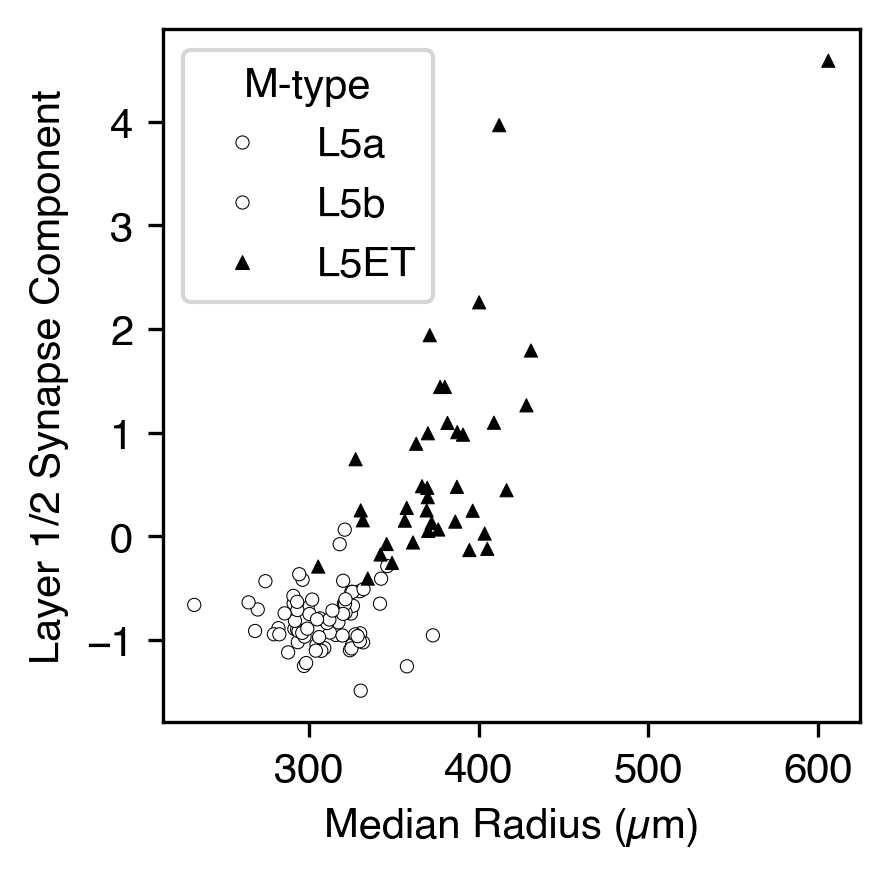

In [33]:
fig, ax = plt.subplots(figsize=(3,3), dpi=300)
l5df = dfct_e.query('hlabel in ["L5a", "L5b", "L5ET"]').reset_index(drop=True)
l5df['hlabel'] = l5df['hlabel'].astype(pd.CategoricalDtype(['L5a', 'L5b', 'L5ET']))
sns.scatterplot(
    x='radius_dist',
    y='syn_count_pca0',
    data=l5df,
    hue='hlabel',
    palette={'L5ET': 'k', 'L5a': 'w', 'L5b': 'w'},
    style='hlabel',
    markers={'L5ET': '^', 'L5a':'o', 'L5b': 'o'}, 
    edgecolor='k',
    s=10,
)

ax.set_ylabel('Layer 1/2 Synapse Component')
ax.set_xlabel('Median Radius (µm)')
ax.legend().set_title('M-type')

['tip_len_dist_dendrite_p50',
 'tip_tort_dendrite_p50',
 'num_syn_dendrite',
 'num_syn_soma',
 'path_length_dendrite',
 'radial_extent_dendrite',
 'syn_dist_distribution_dendrite_p50',
 'syn_size_distribution_soma_p50',
 'syn_size_distribution_dendrite_p50',
 'syn_size_distribution_dendrite_dyn_range',
 'syn_depth_dist_p5',
 'syn_depth_dist_p95',
 'syn_depth_extent',
 'max_density',
 'radius_dist',
 'syn_count_pca0',
 'syn_count_pca1',
 'syn_count_pca2',
 'syn_count_pca3',
 'syn_count_pca4',
 'syn_count_pca5',
 'branch_svd0',
 'branch_svd1',
 'branch_svd2',
 'ego_count_pca0',
 'ego_count_pca1',
 'ego_count_pca2',
 'ego_count_pca3',
 'ego_count_pca4']

In [5]:
raw_df = fc.io_utils.load_features(ct_df['pt_root_id'], feature_dir)

In [6]:
save_figures = False

In [7]:
alpha_shapes = {}
for ct in dfct_e.hlabel.dtype.categories:
    points = np.vstack(dfct_e.query('hlabel == @ct ')[['umap0_raw', 'umap1_raw']].values)
    alpha_shapes[ct] = alphashape.alphashape(points, 2) 

In [ ]:
fig, ax = plt.subplots(dpi=300)

sns.scatterplot(
    x=f"umap0_raw",
    y=f"umap1_raw",
    data=dfct_e,
    hue="hlabel",
    palette=ctype_hues,
    s=6,
    edgecolor='k',
    linewidth=0.15,
)

ax.set_aspect('equal')
ax.legend().set_bbox_to_anchor((1, 1))

for ct, sh in alpha_shapes.items():
    try:
        ax.add_patch(PolygonPatch(sh, alpha=.15, color=ctype_hues[ct], zorder=-10, edgecolor='k', linewidth=0))
    except:
        continue

sns.despine(ax=ax, bottom=True, left=True)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)


In [ ]:
fig, ax = plt.subplots(dpi=150)
sns.scatterplot(
    x=f"umap0_raw",
    y=f"umap1_raw",
    data=dfct_e,
    hue="hlabel",
    palette=ctype_hues,
    s=8,
    # edgecolor='w',
    edgecolor='k',
    linewidth=0.25,
)
ax.set_aspect('equal')
ax.legend().set_bbox_to_anchor((1, 1))

sns.despine(ax=ax, bottom=True, left=True)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

for ct, sh in alpha_shapes.items():
    ax.add_patch(PolygonPatch(sh.buffer(0.05), alpha=.15, color=ctype_hues[ct], zorder=-10, edgecolor='k', linewidth=0))

if save_figures:
    fig.savefig(f"{plot_dir}/clustered_cell_types_umap.pdf", bbox_inches="tight")

In [ ]:
dfct_e.columns

In [ ]:
heatmap_data = dfct_e.query('cell_type!="Unsure E" and cell_type!="6P-U"').pivot_table(
    index="hlabel",
    columns="cell_type",
    values="root_id",
    aggfunc="count",
)
manual_e_columns = ["23P", "4P", "5P-IT", "5P-PT", "5P-NP", "6P-IT", "6P-CT", "WM-P"]
manual_e_labels = ["L2/3", "L4", "L5-IT", "L5-ET", "L5-NP", "L6-IT", "L6-CT", "L6b"]
fig, ax = plt.subplots(figsize=(3, 4), dpi=300)

sns.heatmap(
    heatmap_data[manual_e_columns],
    cmap="viridis",
    square=True,
    annot=True,
    vmin=0,
    vmax=80,
    fmt="d",
    xticklabels=manual_e_labels,
    annot_kws={"fontsize": 6},
)

ax.xaxis.set_ticks_position("top")
_ = ax.set_xticklabels(manual_e_labels, rotation=90)

if save_figures:
    fig.savefig(f"{plot_dir}/manual_cell_type_comparison.pdf", bbox_inches="tight")

In [ ]:
manual_types = ['23P', '4P', '5P-IT', '5P-PT', '5P-NP', '6P-IT', '6P-CT', 'WM-P']

fig, ax = plt.subplots(dpi=150)
sns.scatterplot(
    x=f"umap0_raw",
    y=f"umap1_raw",
    data=dfct_e.query('cell_type in @manual_types'),
    hue="cell_type",
    palette='deep',
    hue_order=manual_types,
    s=5,
)
ax.set_aspect('equal')
ax.legend().set_bbox_to_anchor((1, 1))

sns.despine(ax=ax, bottom=True, left=True)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

if save_figures:
    fig.savefig(f"{plot_dir}/manual_cell_types_umap.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(dpi=150)
sns.scatterplot(
    x=f"umap0_raw",
    y=f"umap1_raw",
    data=dfct_e,
    hue="soma_depth",
    palette='RdPu',
    s=8,
    ec=(0.4, 0.4, 0.4),
)
ax.set_aspect('equal')
ax.legend().set_bbox_to_anchor((1, 1))

sns.despine(ax=ax, bottom=True, left=True)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

if save_figures:
    fig.savefig(f"{plot_dir}/umap_soma_depth.pdf", bbox_inches="tight")

In [ ]:
from matplotlib import colorbar, colors

In [ ]:
col_lookup = {
    "tip_len_dist_dendrite_p50": "Median tip length ($\mu m$)",
    "tip_tort_dendrite_p50": "Median tip tortuosity",
    "num_syn_dendrite": "Num. Syn. Dendrite",
    "num_syn_soma": "Num. Syn. Soma",
    "path_length_dendrite": "Path Length Dendrite ($\mu m$)",
    "radial_extent_dendrite": "Radial Extent ($\mu m$)",
    "syn_dist_distribution_dendrite_p50": "Median synapse distance from soma ($\mu m$)",
    "syn_size_distribution_soma_p50": "Median soma synapse size (a.u.)",
    "syn_size_distribution_dendrite_p50": "Median dendrite synapse size (a.u.)",
    "syn_size_distribution_dendrite_dyn_range": "Dynamic range of dendrite synapse size",
    "syn_depth_dist_p5": "5th percentile synapse depth",
    "syn_depth_dist_p95": "95th percentile synapse depth",
    "syn_depth_extent": "Vertical extent of synapse distribution",
    "max_density": "Median linear synapse density",
    "radius_dist": "Median dendrite radius",
    "syn_count_pca0": "Synapse depth PCA component 0",
    "syn_count_pca1": "Synapse depth PCA component 1",
    "syn_count_pca2": "Synapse depth PCA component 2",
    "syn_count_pca3": "Synapse depth PCA component 3",
    "syn_count_pca4": "Synapse depth PCA component 4",
    "syn_count_pca5": "Synapse depth PCA component 5",
    "ego_count_pca0": "Egocentric synapse PCA component 0",
    "ego_count_pca1": "Egocentric synapse PCA component 1",
    "ego_count_pca2": "Egocentric synapse PCA component 2",
    "ego_count_pca3": "Egocentric synapse PCA component 3",
    "ego_count_pca4": "Egocentric synapse PCA component 4",
    "branch_svd0": "Branch length SVD component 0",
    "branch_svd1": "Branch length SVD component 1",
    "branch_svd2": "Branch length SVD component 2",
}

In [ ]:
from scipy import stats

In [ ]:
dfct_ez = dfct_e.copy()
dfct_ez[feat_cols] = stats.zscore(dfct_e[feat_cols])

fig, ax = plt.subplots(figsize=(4,4), dpi=150)

sns.pointplot(
    x='num_syn_dendrite',
    y='num_syn_soma',
    data=dfct_ez,
    hue='hlabel',
    palette=ctype_hues,
    s=5,
    alpha=1,
    legend=False,
)

In [ ]:
ct_corr = dfct_e.groupby('hlabel').agg(
        num_syn_soma = pd.NamedAgg('num_syn_soma', 'median'),
        num_syn_dendrite= pd.NamedAgg('num_syn_dendrite', 'median')
).corr('pearson')['num_syn_soma']['num_syn_dendrite']

In [ ]:
stats.pearsonr(
    *dfct_e.groupby('hlabel').agg(
        num_syn_soma = pd.NamedAgg('num_syn_soma', 'median'),
        num_syn_dendrite= pd.NamedAgg('num_syn_dendrite', 'median')
).values.T)

In [ ]:
ct_corr_indiv = dfct_e[['num_syn_soma', 'num_syn_dendrite']].corr('pearson')['num_syn_soma']['num_syn_dendrite']

In [ ]:
ct_corr, ct_corr_indiv

In [ ]:
r = stats.pearsonr(
    dfct_e['num_syn_soma'], 
    dfct_e['num_syn_dendrite'],
)

In [ ]:
r.pvalue

In [ ]:
g.ax

In [ ]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
sns.scatterplot(
    data=dfct_e,
    x='num_syn_soma',
    y='num_syn_dendrite',
    hue='hlabel',
    palette=ctype_hues,
    s=5,
    ax=ax,
    edgecolor='k',
)

ax.legend().set_visible(False)
ax.set_xlim(0,200)
ax.set_ylim(0,8000)
ax.set_xlabel('Num. Syn. Soma')
ax.set_ylabel('Num. Syn. Dendrite')
sns.despine(ax=ax)


In [ ]:
fig, ax = plt.subplots(figsize=(4,4), dpi=150)
sns.scatterplot(
    data=dfct_e.groupby('hlabel').agg(
        num_syn_soma = pd.NamedAgg('num_syn_soma', 'median'),
        num_syn_dendrite= pd.NamedAgg('num_syn_dendrite', 'median'),
    ).reset_index(),
    x='num_syn_dendrite',
    y='num_syn_soma',
    hue='hlabel',
    palette=ctype_hues,
    s=50,
    ax=ax,
    edgecolor='k',
)

ax.legend().set_visible(False)
ax.set_ylim(0,200)
ax.set_xlim(0,8000)
ax.set_ylabel('Num. Syn. Soma')
ax.set_xlabel('Num. Syn. Dendrite')
sns.despine(ax=ax)
fig.savefig(f"{plot_dir}/correlation_median_ct.pdf", bbox_inches='tight')

In [ ]:
dfct_ez = dfct_e.copy()
dfct_ez[feat_cols] = stats.zscore(dfct_e[feat_cols])

fig, ax = plt.subplots(figsize=(4,4), dpi=150)

sns.scatterplot(
    x='num_syn_dendrite',
    y='num_syn_soma',
    data=dfct_e.query('num_syn_dendrite<15000'),
    hue='hlabel',
    palette=ctype_hues,
    s=5,
    alpha=1,
    legend=False,
)
    
sns.regplot(
    x='num_syn_dendrite',
    y='num_syn_soma',
    data=dfct_e.query('num_syn_dendrite<15000'),
    # robust=True,
    color='k',
    scatter=False,
    ax=ax,
    truncate=False,
    line_kws={'linewidth':0.75, 'alpha':0.5},
)

ax.set_xlim(0, 15000)
ax.set_ylim(0, 400)
# ax.set_aspect('equal')
sns.despine(ax=ax, trim=True)
ax.set_xlabel('# Syn. Dendrite (z-score)')
ax.set_ylabel('# Syn. Soma (z-score)')

if save_figures:
    fig.savefig(f"{plot_dir}/correlation_all_ct.pdf", bbox_inches='tight')

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

etypes = dfct_e.hlabel.dtype.categories

fit_const = []
fit_lb = []
fit_ub = []
fit_pval = []
for ct in etypes:
    dat = dfct_e.query("hlabel == @ct")
    dat[feat_cols] = stats.zscore(dat[feat_cols])
    res = smf.ols(formula="num_syn_soma ~ num_syn_dendrite + 1", data=dat).fit()
    fit_const.append(res.params.num_syn_dendrite)
    fit_pval.append(res.pvalues.num_syn_dendrite)
    fit_lb.append(res.conf_int().loc["num_syn_dendrite"][0])
    fit_ub.append(res.conf_int().loc["num_syn_dendrite"][1])

res_df = pd.DataFrame(
    {
        "cell_type": etypes,
        "coef": fit_const,
        "lb": fit_lb,
        "ub": fit_ub,
        "pval": fit_pval,
    }
)

res_df['cell_type'] = res_df['cell_type'].astype(pd.CategoricalDtype(etypes, ordered=True))

_, pval_m, _, _ = sm.stats.multipletests(res_df['pval'])
res_df['pval_corrected'] = pval_m

res_df['sig'] = res_df['pval_corrected']<0.05

In [ ]:
g = sns.lmplot(
    x='num_syn_dendrite',
    y='num_syn_soma',
    data=dfct_e,
    sharex=False,
    sharey=False,
    hue='hlabel',
    palette=ctype_hues,
    col='hlabel',
    col_wrap=4,
)

if save_figures:
    g.fig.savefig(f"{plot_dir}/soma_dendrite_correlation_all_cell_types.pdf", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(4,2.5), dpi=150)

sns.pointplot(
    x='cell_type',
    y='coef',
    data=res_df,
    hue='cell_type',
    ax=ax,
    palette=ctype_hues,
    scale=1,
)

ax.legend().set_visible(False)

ax.errorbar(
    res_df.index,
    res_df.coef,
    np.abs((res_df[['lb', 'ub']].values-np.atleast_2d(res_df.coef.values).T).T),
    color='k',
    linestyle='none',
    elinewidth=2,
    zorder=-10
)

ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color=(0.5, 0.5, 0.5), linestyle=":", zorder=-20)

sns.despine(ax=ax, offset=1, trim=True)
ax.set_xticklabels(etypes, rotation=90)
ax.set_ylabel('Coefficient')
ax.set_xlabel(None)

if save_figures:
    fig.savefig(f"{plot_dir}/correlation_soma_dendrite_ct.pdf", bbox_inches='tight')
    res_df.to_csv(f"{plot_data_dir}/correlation_soma_dendrite.csv")

In [ ]:
from caveclient import CAVEclient
client = CAVEclient('minnie65_phase3_v1')

In [ ]:
fig, ax = plt.subplots(figsize=(2.2,1), dpi=150)
sns.histplot(
    x='hlabel',
    data=dfct_e,
    hue='hlabel',
    palette=ctype_hues,
    alpha=1,
    edgecolor=None,
    shrink=0.8,
    legend=False,
    ax=ax,
    zorder=10,
)

ax.grid(axis='y', color=(0.5,0.5, 0.5), alpha=0.5, linestyle=':', zorder=-10)

ax.set_yticks(np.linspace(0,150,4, endpoint=True))
ax.xaxis.set_tick_params(rotation=90, labelsize=6)
ax.yaxis.set_tick_params(labelsize=7)
ax.set_xlabel(None)
ax.set_ylabel('Count', fontdict={'size': 7})

sns.despine(ax=ax, offset=2, trim=True)
if save_figures:
    fig.savefig(f'{plot_dir}/ct_histogram.pdf', bbox_inches='tight')
    dfct_e.groupby('hlabel').count()[['soma_depth']].rename({'soma_depth': 'num_cell'}).to_csv(f"{plot_data_dir}/ct_histogram.csv")

In [ ]:
for col in feat_cols:
    fig, axes = plt.subplots(figsize=(5,4), dpi=150, nrows=2, gridspec_kw={'height_ratios': [12,1]})
    ax = axes[0]
    sns.scatterplot(
        x=f"umap0_raw",
        y=f"umap1_raw",
        data=dfct_e,
        hue=col,
        hue_norm=tuple(np.percentile(dfct_e[col], (2.5, 97.5))),
        palette="magma",
        edgecolor='k',
        s=8,
        legend=False,
        ax=ax,
    )
    ax.set_aspect("equal")

    sns.despine(ax=ax, bottom=True, left=True)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    ax = axes[1]
    cb1 = colorbar.ColorbarBase(
        ax,
        cmap=sns.color_palette("magma", as_cmap=True),
        norm=colors.Normalize(
            vmin=np.percentile(dfct_e[col], 2.5), vmax=np.percentile(dfct_e[col], 97.5)
        ),
        orientation="horizontal",
    )
    ax.set_title(col_lookup.get(col))
    if save_figures:
        fig.savefig(f"{plot_dir}/umap_feature_column_{col}.pdf", bbox_inches="tight")
        plt.close(fig)

In [ ]:
for val in feat_cols:
    fig, ax = plt.subplots(figsize=(2.5, 5), dpi=150)
    sns.scatterplot(
        x=val,
        y="soma_depth",
        hue="hlabel",
        ax=ax,
        palette=ctype_hues,
        data=dfct_e,
        s=3,
        ec=(0.5, 0.5, 0.5),
        legend=False,
    )
    xlim = ax.get_xlim()
    ax.hlines(
        layer_bounds,
        xlim[0],
        xlim[1],
        color=(0.5, 0.5, 0.5),
        linewidth=0.5,
        linestyle="--",
        zorder=-10,
    )

    ax.set_ylim(*height_bounds)
    ax.invert_yaxis()
    sns.despine(ax=ax)
    ax.set_ylabel('Soma Depth ($\mu m$)')
    ax.set_xlabel(col_lookup.get(val))
    
    if save_figures:
        fig.savefig(f"{plot_dir}/prop_vs_depth_{val}.pdf", bbox_inches="tight")
        plt.close(fig)

ValueError: The palette dictionary is missing keys: {'L3b', 'L5b', 'L6tall-a', 'L6tall-c', 'L4b', 'L2c', 'L2a', 'L4c', 'L6short-b', 'L6wm', 'L3a', 'L2b', 'L5NP', 'L5ET', 'L6tall-b', 'L6short-a', 'L5a', 'L4a'}

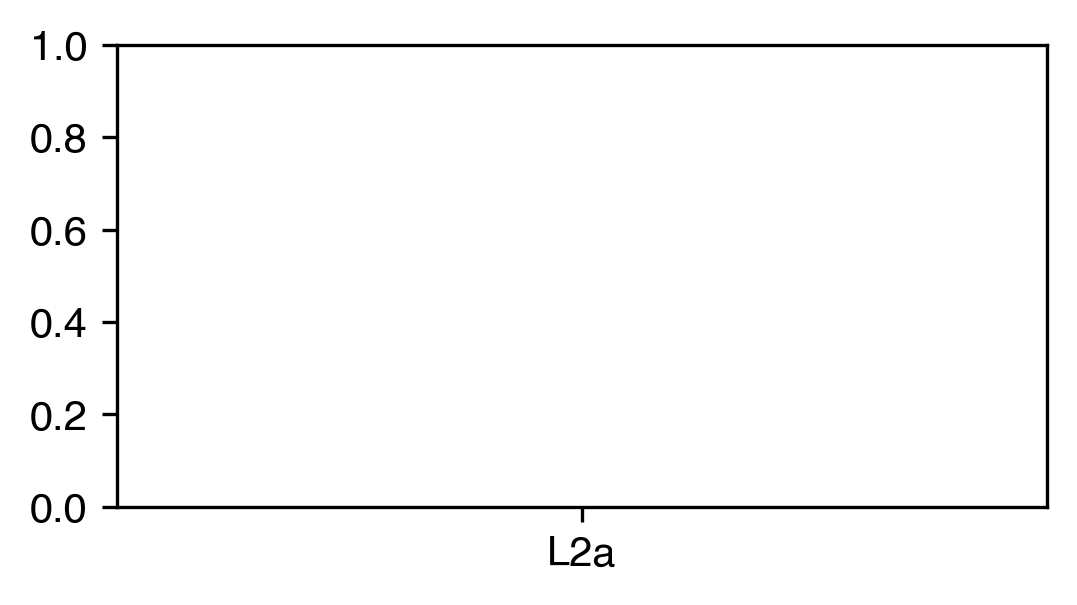

In [12]:
fig, ax = plt.subplots(figsize=(4, 2), dpi=300)

sns.swarmplot(
    x="hlabel",
    y="soma_depth",
    data=dfct_e,
    hue="hlabel",
    s=0.8,
    palette=ctype_hues,
    ax=ax,
    alpha=1,
)

ax.invert_yaxis()
ax.legend().set_visible(False)

sns.despine(ax=ax, offset=5)
ax.hlines(
    layer_bounds,
    ax.get_xlim()[0],
    ax.get_xlim()[1],
    color=(0.5, 0.5, 0.5),
    linewidth=0.5,
    linestyle="--",
    zorder=-10,
)
ax.xaxis.set_tick_params(labelsize=7, rotation=45)
ax.yaxis.set_tick_params(labelsize=7)
ax.set_ylabel('Soma Depth ($\mu m$)')
_=ax.set_xlabel(None)

if save_figures:
    fig.savefig(f'{plot_dir}/cat_vs_soma_depth.pdf', bbox_inches='tight')

In [ ]:
for val in feat_cols:
    fig, ax = plt.subplots(figsize=(4, 3), dpi=150, facecolor='w')
    sns.swarmplot(
        x="hlabel",
        y=val,
        data=dfct_e,
        hue="hlabel",
        s=1,
        palette=ctype_hues,
        ax=ax,
        alpha=1,
        zorder=-10,
    )

    ax.set_ylabel(col_lookup.get(val))
    ax.set_xlabel(None)
    ax.xaxis.set_tick_params(labelsize=6, rotation=45)

    ax.legend().set_visible(False)
    sns.despine(ax=ax, offset=5)
    
    plt.savefig(f"{plot_dir}/feat_swarm_{val}.pdf", bbox_inches="tight")
    plt.close(fig)

In [ ]:
from scipy import stats

In [ ]:
['Soma Depth'] + list(col_lookup.values())

In [ ]:
label_col = "hlabel"
feat_cols_with_depth = ["soma_depth"] + feat_cols

vline_locs = np.cumsum(dfct_e.groupby(label_col).count()["root_id"].values)
datz = stats.zscore(dfct_e[feat_cols].values)
h = datz.shape[1]

fig, ax = plt.subplots(figsize=(20, 4), dpi=300)
sns.heatmap(
    datz[dfct_e.sort_values(by=[label_col, "soma_depth"]).index].T,
    cmap="RdBu_r",
    center=0,
    vmin=-2,
    vmax=2,
)

ax.set_yticks(np.arange(datz.shape[1]) + 0.5)
ax.vlines(vline_locs, 0, h, color="k", linewidth=1, alpha=1)
_ = ax.set_yticklabels(list(col_lookup.values()), rotation=0, fontdict={"size": 5})
_ = ax.set_xticks(
    np.diff(np.concatenate(([0], vline_locs))) / 2
    + np.concatenate(([0], vline_locs[:-1]))
)
_ = ax.set_xticklabels(list(dfct_e.hlabel.dtype.categories), rotation=0)
fig.savefig(f'{plot_dir}/features_cats.pdf', bbox_inches='tight')

In [ ]:
ct_list_e = dfct_e.hlabel.dtype.categories

In [ ]:
fig, ax = plt.subplots(figsize=(4,4), dpi=300)

sns.heatmap(
    stats.zscore(
        dfct_e.pivot_table(index="hlabel", values=feat_cols, aggfunc="median")[feat_cols]
    ).T,
    cmap="RdBu_r",
    center=0,
    vmin=-1.75,
    vmax=1.75,
    ax=ax,
)
ax.set_aspect("equal")
ax.set_yticks(np.arange(len(feat_cols)) + 0.5)
_ = ax.set_yticklabels(feat_cols, fontsize=5)
_ = ax.set_xticks(np.arange(len(ct_list_e)) + 0.5)
_ = ax.set_xticklabels(list(ct_list_e), rotation=90, fontsize=5)

plt.tight_layout()
fig.savefig('plots/features_cats_avg.pdf', bbox_inches='tight')

In [ ]:
from common_setup import *
from plotting_code import plot_layers

In [ ]:
import feature_clustering as fc
import tqdm
from affine_transform import minnie_column_transform_nm, minnie_column_transform
tform_nm = minnie_column_transform_nm()
tform = minnie_column_transform()
from numbers import Number
from matplotlib import colors

clr = [0.3, 0.9, 0.8]


def path_line(path, sk, x_ind=0, y_ind=1, rescale=1):
    xs = sk.vertices[path, x_ind].squeeze()
    ys = sk.vertices[path, y_ind].squeeze()
    return xs / rescale, ys / rescale


def all_paths(sk, x_ind=0, y_ind=1, rescale=1):
    all_xs = []
    all_ys = []
    for path in sk.cover_paths_with_parent():
        xs, ys = path_line(path, sk, x_ind=x_ind, y_ind=y_ind, rescale=rescale)
        all_xs.append(np.atleast_1d(xs))
        all_xs.append(np.array([np.nan]))
        all_ys.append(np.atleast_1d(ys))
        all_ys.append(np.array([np.nan]))
    return np.concatenate(all_xs), np.concatenate(all_ys)


def darken_color(clr, delta=0.3):
    clr_hsv = colors.rgb_to_hsv(clr)
    vdiff = clr_hsv[2]
    return colors.hsv_to_rgb([x - delta * y for x, y in zip(clr_hsv, [0, 0, vdiff])])


def lighten_color(clr, delta=0.3):
    clr_hsv = colors.rgb_to_hsv(clr)
    vdiff = 1 - clr_hsv[2]
    return colors.hsv_to_rgb([x + delta * y for x, y in zip(clr_hsv, [0, 0, vdiff])])

def sample_width(
    root_id,
    x_offset=0,
    rescale=1000,
    dendrite_only=True,
    axon_anno=None,
    dendrite_anno=None,
    min_x=None,
    transform=None,
):
    if isinstance(root_id, Number):
        nrn = fc.io_utils.load_root_id(root_id, project_paths)
    else:
        nrn = root_id
    
    if transform:
        nrn = nrn.copy()
        nrn.skeleton.vertices = transform.apply(nrn.skeleton.vertices)

    soma_pt = np.atleast_2d(nrn.skeleton.vertices[nrn.skeleton.root]) / rescale
    soma_pt_x = soma_pt[0, 0]

    if axon_anno is not None:
        is_axon = nrn.anno[axon_anno].mesh_mask
    else:
        is_axon = ~nrn.anno[dendrite_anno].mesh_mask
        
    with nrn.mask_context(~is_axon) as nrnf:
        x_dend, y_dend = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=rescale)
        all_x = x_dend[~np.isnan(x_dend)]

    if not dendrite_only:
        with nrn.mask_context(is_axon) as nrnf:
            x_axon, y_axon = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=rescale)
        all_x = np.concatenate((x_axon[~np.isnan(x_axon)], all_x))
        
    if min_x is not None:
        if np.min(all_x - soma_pt_x) + x_offset < min_x:
            x_offset = min_x + np.abs(np.min(all_x - soma_pt_x)) - soma_pt_x
    else:
        x_offset = x_offset - soma_pt_x

    return max(all_x+x_offset)
    
def plot_neuron(
    root_id,
    color,
    x_offset=0,
    ax=None,
    dendrite_only=True,
    axon_color=None,
    rescale=1000,
    axon_anno=None,
    dendrite_anno=None,
    axon_kwargs={},
    dendrite_kwargs={},
    soma_kwargs={},
    min_x=None,
    return_extent=False,
    transform=None,
    annotation=None,
    annotation_y=None,
    annotation_kwargs={},
):
    if isinstance(root_id, Number):
        nrn = fc.io_utils.load_root_id(root_id, project_paths)
    else:
        nrn = root_id
    
    if transform:
        nrn = nrn.copy()
        nrn.skeleton.vertices = transform.apply(nrn.skeleton.vertices)
        
    soma_pt = np.atleast_2d(nrn.skeleton.vertices[nrn.skeleton.root]) / rescale
    soma_pt_x = soma_pt[0, 0]
    
    if axon_anno is not None:
        is_axon = nrn.anno[axon_anno].mesh_mask
    else:
        is_axon = ~nrn.anno[dendrite_anno].mesh_mask
        
    with nrn.mask_context(~is_axon) as nrnf:
        x_dend, y_dend = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=rescale)
        all_x = x_dend[~np.isnan(x_dend)]

    if not dendrite_only:
        with nrn.mask_context(is_axon) as nrnf:
            x_axon, y_axon = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=rescale)
        all_x = np.concatenate((x_axon[~np.isnan(x_axon)], all_x))
        
    if min_x is not None:
        if np.min(all_x - soma_pt_x) + x_offset < min_x:
            x_offset = min_x + np.abs(np.min(all_x - soma_pt_x)) - soma_pt_x
    else:
        x_offset = x_offset - soma_pt_x

    if ax is None:
        ax = plt.gca()

    if axon_color is None:
        axon_color = lighten_color(color)

    if not dendrite_only:
        ax.plot(x_axon + x_offset, y_axon, color=axon_color, **axon_kwargs)
    ax.plot(x_dend + x_offset, y_dend, color=color, **dendrite_kwargs)

    ax.scatter(
        soma_pt[:, 0] + x_offset,
        soma_pt[:, 1],
        color=color,
        **soma_kwargs,
    )
    if ax.get_ylim()[0] < ax.get_ylim()[1]:
        ax.invert_yaxis()
    if annotation and annotation_y:
        ax.annotate(annotation, [soma_pt[:, 0] + x_offset, annotation_y], **annotation_kwargs)
    if return_extent:
        return min(all_x+x_offset), max(all_x+x_offset)
    
    
def load_neuron(root_id, skel_dir):
    nrn = meshwork.load_meshwork(
        f"{skel_dir}/{root_id}.h5"
    )

    fc.io_utils.apply_dendrite_mask(nrn)
    fc.io_utils.peel_sparse_segments(nrn, 0.1)

    dend_mask = nrn.mesh_mask.copy()
    nrn.reset_mask()

    nrn.anno.add_annotations("dendrite", np.flatnonzero(dend_mask), mask=True)
    return nrn
    
def plot_cell_lineup(
    df,
    ax,
    root_id,
    hue,
    palette,
    skel_dir,
    offset=300,
    spacing="tight",
    spacing_gap=0,
    dendrite_only=False,
    axon_anno=None,
    dendrite_anno=None,
    axon_kwargs=None,
    dendrite_kwargs=None,
    soma_kwargs=None,
    layer_bounds=None,
    height_bounds=None,
    transform=None,
    max_width=None,
    annotation_column=None,
    annotation_y=None,
    annotation_kwargs={},
):
    if axon_kwargs is None:
        axon_kwargs = {"linewidth": 0.5}
    if dendrite_kwargs is None:
        dendrite_kwargs = {"linewidth": 1}
    if soma_kwargs is None:
        soma_kwargs = {
            "s": 18,
            "edgecolors": (1, 1, 1),
            "linewidths": 0.75,
            "zorder": 20,
        }

    xmax = 0
    for ii, (_, row) in enumerate(df.iterrows()):
        
        if spacing == "tight":
            min_x = xmax + spacing_gap
            x_offset = xmax + spacing_gap
        elif spacing == "uniform":
            min_x = None
            x_offset = ii * offset
        else:
            raise ValueError('Spacing must be "tight" or "uniform"')
            
        if dendrite_only:
            dendrite_color=palette[row[hue]]
        else:
            dendrite_color=darken_color(palette[row[hue]])
        try:
            if row[hue] == "PTC":
                del_color = 0.5
            else:
                del_color = 0.3
        except:
            del_color = 0.3
            
        if transform is None:
            rescale = 1000
        else:
            rescale = 1

        try:
            nrn = load_neuron(row[root_id], skel_dir)
        except:
            continue

        if max_width is not None:
            new_max = sample_width(
                nrn,
                x_offset=x_offset,
                transform=transform,
                axon_anno=axon_anno,
                dendrite_anno=dendrite_anno,
                dendrite_only=dendrite_only,
                rescale=rescale,
            )
            if new_max > max_width:
                ax.set_aspect("equal")
                if layer_bounds is not None and len(df)>0:
                    plotting_code.plot_layers(
                        layer_bounds,
                        depth_bounds=height_bounds,
                        span=(first_min-10, max_width),
                        ax=ax,
                        linestyle="--",
                        color=(0.5, 0.5, 0.5),
                        alpha=0.5,
                        linewidth=1,
                    )
                return df.iloc[ii:]
        
        if annotation_column is not None:
            annotation = row[annotation_column]
        else:
            annotation = None
        
        xmin, xmax = plot_neuron(
            nrn,
            ax=ax,
            x_offset=x_offset,
            color=dendrite_color,
            dendrite_only=dendrite_only,
            axon_anno=axon_anno,
            dendrite_anno=dendrite_anno,
            axon_color=lighten_color(palette[row[hue]], delta=del_color),
            axon_kwargs=axon_kwargs,
            dendrite_kwargs=dendrite_kwargs,
            soma_kwargs=soma_kwargs,
            min_x=min_x,
            return_extent=True,
            transform=transform,
            rescale=rescale,
            annotation=annotation,
            annotation_y=annotation_y,
            annotation_kwargs=annotation_kwargs,
        )
        
        if ii == 0:
            first_min = xmin
    
    ax.set_aspect("equal")
    if layer_bounds is not None and len(df)>0:
        if max_width is not None:
            span_max = max_width
        else:
            span_max = xmax+10
        plotting_code.plot_layers(
            layer_bounds,
            depth_bounds=height_bounds,
            span=(first_min-10, span_max),
            ax=ax,
            linestyle="--",
            color=(0.5, 0.5, 0.5),
            alpha=0.5,
            linewidth=1,
        )

In [ ]:
e_colors = sns.color_palette('RdPu', n_colors=9)

soma_color = e_colors[8]
prox_color = e_colors[6]
apic_color = e_colors[3]
dist_color = e_colors[5]

# self.base_ind = 5
# self.soma_ind = 8
# self.apical_ind = 3
# self.prox_ind = 6

In [ ]:
version

In [ ]:
root_id = 864691135590140683

fig, ax = plt.subplots(figsize=(4,3), dpi=300)

apical_color = e_colors[3]
prox_color = e_colors[6]
basal_color = e_colors[5]
soma_color = e_colors[8]

apical_kwargs = {"linewidth": 0.75}
prox_kwargs = {"linewidth": 1.5}
dist_kwargs = {"linewidth": 0.75}

soma_kwargs = {
    "s": 40,
    "edgecolors": (1, 1, 1),
    "linewidths": 0.75,
    "zorder": 20,
}

dendrite_anno='is_dendrite'
dendrite_only=True
x_offset = 0

nrn = fc.io_utils.load_root_id(root_id, project_paths)
    
if transform:
    nrn.skeleton.vertices = tform_nm.apply(nrn.skeleton.vertices)
        
soma_pt = np.atleast_2d(nrn.skeleton.vertices[nrn.skeleton.root])
soma_pt_x = soma_pt[0, 0]
    
is_axon = ~nrn.anno[dendrite_anno].mesh_mask
is_apical = np.logical_and(
    np.logical_and(
        nrn.anno['is_apical'].mesh_mask,
        ~is_axon,
    ),
    nrn.MeshIndex(nrn.distance_to_root() >= 65).to_mesh_mask
)
is_proximal = np.logical_or(
    np.logical_and(
        nrn.MeshIndex(nrn.distance_to_root() < 65).to_mesh_mask,
        ~is_axon,
    ),
    nrn.root_region.to_mesh_mask
)
is_distal = np.logical_and(
    np.logical_and(
        ~is_proximal,
        ~is_axon,
    ),
    ~is_apical,
)

with nrn.mask_context(is_proximal) as nrnf:
    x_prox, y_prox = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=1)

with nrn.mask_context(is_distal) as nrnf:
    x_dist, y_dist = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=1)

with nrn.mask_context(is_apical) as nrnf:
    x_apic, y_apic = all_paths(nrnf.skeleton, x_ind=0, y_ind=1, rescale=1)

ax.plot(x_prox, y_prox, color=prox_color, **prox_kwargs)
ax.plot(x_dist, y_dist, color=basal_color, **dist_kwargs)
ax.plot(x_apic, y_apic, color=apical_color, **apical_kwargs)

ax.scatter(
    soma_pt[:, 0] + x_offset,
    soma_pt[:, 1],
    color=soma_color,
    **soma_kwargs,
)
ax.set_aspect('equal')
if ax.get_ylim()[0] < ax.get_ylim()[1]:
    
    ax.invert_yaxis()    

sns.despine(ax=ax, left=True, bottom=True)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

fig.savefig(f"{plot_dir}/morpho_color_apical_example.pdf")



In [ ]:
e_cell_types = dfct_e.hlabel.dtype.categories.values


In [ ]:
e_ctype_pal = ctype_hues

In [ ]:
n_sample = 10

sample_dfs = []
for ct in list(e_cell_types):
    ct_specific_df = dfct_e.query(f"hlabel==@ct")
    if len(ct_specific_df) > n_sample:
        sample_dfs.append(ct_specific_df.sample(n_sample))
    else:
        sample_dfs.append(ct_specific_df)

plot_neuron_df = pd.concat(sample_dfs)


offset_amnt = 300
for ii, ct in enumerate(e_cell_types):
    fig, ax = plt.subplots( figsize=(15,4), facecolor='w', dpi=300)
    df_temp = plot_neuron_df.query("hlabel==@ct")
    offsets = np.arange(0, len(df_temp) * offset_amnt + 1, offset_amnt)
    plot_cell_lineup(
        df_temp.reset_index(),
        ax=ax,
        root_id='root_id',
        hue='hlabel',
        palette=ctype_hues,
        dendrite_anno='is_dendrite',
        dendrite_only=True,
        layer_bounds=layer_bounds,
        height_bounds=height_bounds,
        spacing_gap=10,
        transform=tform_nm,
    )

    ax.set_aspect("equal")
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_ylim(*height_bounds[::-1])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    fig.savefig(f"{plot_dir}/example_morphos_ct_{ct}.pdf")
    plt.close(fig)

In [ ]:
ctype_hues

In [ ]:
e_ctype_pal

In [ ]:
from caveclient import CAVEclient

In [ ]:
client = CAVEclient('minnie65_phase3_v1')

In [ ]:
ts = client.materialize.get_timestamp(795)

In [ ]:
nuc_df = client.materialize.tables.nucleus_detection_v0().query(timestamp=ts)

In [ ]:
dfct_e = dfct_e.merge(
    nuc_df[['pt_root_id', 'id']].drop_duplicates('pt_root_id', keep=False),
    on='pt_root_id',
    how='left',
).rename(
    columns={'id': 'nuc_id'},
)

In [ ]:
sk_dir

In [ ]:
use_df = dfct_e.sort_values(by='soma_depth').copy()

ii = 0
while use_df is not None:
    fig, ax = plt.subplots( figsize=(10, 2), facecolor='w', dpi=300)
    use_df = plot_cell_lineup(
        use_df,
        ax=ax,
        skel_dir=sk_dir,
        root_id='root_id',
        hue='hlabel',
        palette=e_ctype_pal,
        dendrite_anno='dendrite',
        dendrite_only=True,
        layer_bounds=layer_bounds,
        height_bounds=height_bounds,
        spacing_gap=10,
        transform=tform_nm,
        max_width=3750,
        annotation_column='nuc_id',
        annotation_y=900,
        annotation_kwargs={'horizontalalignment': 'center', 'fontproperties':{'size': 5}}
    )

    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_ylim(*height_bounds[::-1])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    plt.tight_layout()
    fig.savefig(f"{plot_dir}/alt_full_morpho_row_{ii}.pdf")
    plt.close(fig)
    ii += 1
    print(f"Finished round {ii} | {len(use_df)} remaining...")

In [ ]:
import pdb
pdb.pm()

In [ ]:
first_row = ["L2a", "L2b", "L2c", "L3a", "L3b", "L3c"]
second_row = ["L4a", "L4b", "L4c", "L5a", "L5b", "L5ET", "L5NP"]
third_row = ["L6short-a", "L6short-b", "L6tall-a","L6tall-b", "L6tall-c", "L6wm"]

In [ ]:
example_df = dfct_e.groupby('hlabel').sample(3)

In [ ]:
fig, ax = plt.subplots( figsize=(15,3), facecolor='w', dpi=300)

plot_cell_lineup(
    example_df.query('hlabel in @first_row'),
    ax=ax,
    root_id='root_id',
    hue='hlabel',
    palette=e_ctype_pal,
    dendrite_anno='is_dendrite',
    dendrite_only=True,
    layer_bounds=layer_bounds,
    height_bounds=height_bounds,
    spacing_gap=10,
    transform=tform_nm,
)

ax.set_aspect("equal")
sns.despine(ax=ax, left=True, bottom=True)
ax.set_ylim(*height_bounds[::-1])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

fig.savefig(f"{plot_dir}/example_morphos_ct_single_each_row_one.pdf", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots( figsize=(15,3), facecolor='w', dpi=300)

plot_cell_lineup(
    example_df.query('hlabel in @second_row'),
    ax=ax,
    root_id='root_id',
    hue='hlabel',
    palette=e_ctype_pal,
    dendrite_anno='is_dendrite',
    dendrite_only=True,
    layer_bounds=layer_bounds,
    height_bounds=height_bounds,
    spacing_gap=10,
    transform=tform_nm,
)

ax.set_aspect("equal")
sns.despine(ax=ax, left=True, bottom=True)
ax.set_ylim(*height_bounds[::-1])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

fig.savefig(f"{plot_dir}/example_morphos_ct_single_each_row_two.pdf", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots( figsize=(15,3), facecolor='w', dpi=300)

plot_cell_lineup(
    example_df.query('hlabel in @third_row'),
    ax=ax,
    root_id='root_id',
    hue='hlabel',
    palette=e_ctype_pal,
    dendrite_anno='is_dendrite',
    dendrite_only=True,
    layer_bounds=layer_bounds,
    height_bounds=height_bounds,
    spacing_gap=10,
    transform=tform_nm,
)

ax.set_aspect("equal")
sns.despine(ax=ax, left=True, bottom=True)
ax.set_ylim(*height_bounds[::-1])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

fig.savefig(f"{plot_dir}/example_morphos_ct_single_each_row_three.pdf", bbox_inches='tight')

---

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)
sns.heatmap(
    stats.zscore(dfct_e[feat_cols]).corr(),
    square=True,
    mask=np.eye(len(feat_cols)).astype(bool),
    cmap='RdBu_r',
    center=0,
    xticklabels=[col_lookup.get(col) for col in feat_cols],
    yticklabels=[col_lookup.get(col) for col in feat_cols],
)
ax.yaxis.set_tick_params(labelsize=5)
ax.xaxis.set_tick_params(labelsize=5)
plt.savefig(f"{plot_dir}/feature_correlation.pdf", bbox_inches='tight')

---

In [ ]:
depth_bins = fc.extraction.make_depth_bins(height_bounds, 50)

mean_syn_dist = {}
all_syn_dist = {}

for lbl in list(etypes):
    root_ids = dfct_e.query("hlabel==@lbl")["root_id"].values
    mean_syn_dist[lbl] = np.mean(
        np.vstack(
            raw_df.set_index("root_id").loc[root_ids]["syn_count_depth_dendrite"].values
        ),
        axis=0,
    )
    all_syn_dist[lbl] = np.vstack(
            raw_df.set_index("root_id").loc[root_ids]["syn_count_depth_dendrite"].values
    )

In [ ]:
ct_list = [x for x in etypes]
clrs = np.vstack(ctype_hues.values())

In [ ]:
l2_groups = slice(0, 5)
l4_groups = slice(5, 8)
l5_groups = slice(8, 12)
l6_groups = slice(12, len(etypes))

fig, axes = plt.subplots(
    figsize=(3,5*4), dpi=150, nrows=4, sharex=True, sharey=True,
)

ax = axes[0]
lines = []

for clr, ct in zip(clrs[l2_groups], ct_list[l2_groups]):
    line, = ax.plot(
        mean_syn_dist[ct],
        depth_bins[0:-1] + np.diff(depth_bins) / 2,
        color=clr,
        alpha=0.75,
    )
    lines.append(line)
ax.set_xlim(-10,1100)
ax.set_xticks(np.array([0,25,50])*np.diff(depth_bins)[0])
ax.xaxis.set_major_formatter(lambda x, _: f'{x/np.diff(depth_bins)[0]:.0f}')
plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    ax.get_xlim(),
    color=(0.5, 0.5, 0.5),
    linewidth=1,
    linestyle=":",
    ax=ax,
)
ax.set_title('L2/3 groups')

ax = axes[1]
for clr, ct in zip(clrs[l4_groups], ct_list[l4_groups]):
    line, = ax.plot(
        mean_syn_dist[ct],
        depth_bins[0:-1] + np.diff(depth_bins) / 2,
        color=clr,
        alpha=0.75,
    )
    lines.append(line)
ax.set_xlim(-10,1100)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    ax.get_xlim(),
    color=(0.5, 0.5, 0.5),
    linewidth=1,
    linestyle=":",
    ax=ax,
)
ax.set_title('L4 groups')

ax = axes[2]
for clr, ct in zip(clrs[l5_groups], ct_list[l5_groups]):
    line, = ax.plot(
        mean_syn_dist[ct],
        depth_bins[0:-1] + np.diff(depth_bins) / 2,
        color=clr,
        alpha=0.75,
    )
    lines.append(line)
ax.set_xlim(-10,1100)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    ax.get_xlim(),
    color=(0.5, 0.5, 0.5),
    linewidth=1,
    linestyle=":",
    ax=ax,
)
ax.set_title('L5 groups')

ax = axes[3]
for clr, ct in zip(clrs[l6_groups], ct_list[l6_groups]):
    
    line, = ax.plot(
        mean_syn_dist[ct],
        depth_bins[0:-1] + np.diff(depth_bins) / 2,
        color=clr,
        alpha=0.75,
    )
    lines.append(line)
ax.set_xlim(-10,1100)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    ax.get_xlim(),
    color=(0.5, 0.5, 0.5),
    linewidth=1,
    linestyle=":",
    ax=ax,
)
ax.set_title('L6 groups')

for ax in axes:
    sns.despine(ax=ax,offset=4)
    ax.set_ylim(height_bounds[1]-130, height_bounds[0])
    
axes[0].set_xlabel('Input syn. / 1 $\mu m$ depth')
axes[3].legend(lines, ct_list_e)

fig.savefig(f'{plot_dir}/depth_profile_by_catgory.pdf', bbox_inches='tight')

In [ ]:
fig, axes = plt.subplots(
    figsize=(3*len(ct_list_e),5), dpi=150, ncols=len(ct_list_e), sharey=True,
)

for ax, ct in zip(axes, ct_list_e):
    _ = ax.plot(
        all_syn_dist[ct].T,
        depth_bins[0:-1] + np.diff(depth_bins) / 2,
        color=ctype_hues[ct],
        linewidth=0.25,
        alpha=0.2,
    )
    ax.plot(
        mean_syn_dist[ct],
        depth_bins[0:-1] + np.diff(depth_bins) / 2,
        color=ctype_hues[ct],
        linewidth=1,
        alpha=1,
    )
    plotting_code.plot_layers(
        layer_bounds,
        height_bounds,
        ax.get_xlim(),
        color=(0.5, 0.5, 0.5),
        linewidth=1,
        linestyle=":",
        ax=ax,
    )

for ax in axes:
    sns.despine(ax=ax,offset=4)
    ax.set_ylim(height_bounds[1]-130, height_bounds[0])


In [ ]:
fig, ax = plt.subplots(
    figsize=(3,5), dpi=150,
)

lines = []

for clr, ct in zip(clrs[l2_groups], ct_list[l2_groups]):
    line, = ax.plot(
        mean_syn_dist[ct],
        depth_bins[0:-1] + np.diff(depth_bins) / 2,
        color=clr,
        alpha=0.75,
    )
    lines.append(line)
ax.set_xlim(-10,1100)
ax.set_xticks(np.array([0,25,50])*np.diff(depth_bins)[0])
ax.xaxis.set_major_formatter(lambda x, _: f'{x/np.diff(depth_bins)[0]:.0f}')
plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    ax.get_xlim(),
    color=(0.5, 0.5, 0.5),
    linewidth=1,
    linestyle=":",
    ax=ax,
)
ax.set_title('L2/3 groups')


In [ ]:
fig, axes = plt.subplots(
    figsize=(3*len(ct_list_e),3), dpi=150, ncols=len(ct_list_e), sharey=True, sharex=True,
)

for ax, ct in zip(axes, ct_list_e):
    ct_root_ids = dfct_e.query('hlabel == @ct')['pt_root_id']
    profile = np.vstack(raw_df.query('root_id in @ct_root_ids')['egocentric_bins'])
    profile = profile / np.atleast_2d(profile.sum(axis=1)).T
    _ = ax.plot(
        profile.T,
        np.linspace(-100,100, 13),
        color=ctype_hues[ct],
        alpha=0.2,
        linewidth=0.5,
        zorder=10,
    )
    ax.set_title(ct)
    ax.set_xlabel('Fraction syn.')
    ax.invert_yaxis()
    
for ax in axes:
    ax.set_xlim(-0.05, 0.4)
    ax.hlines(0, ax.get_xlim()[0], ax.get_xlim()[1], color='k', linestyle=':', alpha=0.5, zorder=-10)
    sns.despine(ax=ax, offset=2)
    
fig.savefig(f"{plot_dir}/egocentric_profiles.pdf", bbox_inches='tight')

In [ ]:
mean_values = dfct_e.pivot_table(index="hlabel", values=feat_cols, aggfunc="mean")[feat_cols].T

In [ ]:
mean_values[l23s]

In [ ]:
l23s = ["L2a", "L2b", "L3a", "L3b", "L3c"]
proper_features = ['tip_len_dist_dendrite_p50', 'tip_tort_dendrite_p50',
       'num_syn_dendrite', 'num_syn_soma', 'path_length_dendrite',
       'radial_extent_dendrite', 'syn_dist_distribution_dendrite_p50',
       'syn_size_distribution_soma_p50', 'syn_size_distribution_dendrite_p50',
       'syn_size_distribution_dendrite_dyn_range', 'syn_depth_dist_p5',
       'syn_depth_dist_p95', 'syn_depth_extent', 'max_density', 'radius_dist']
np.std(mean_values[l23s], axis=1) / np.mean(mean_values[l23s], axis=1)[proper_features]

In [ ]:
dfct_e['num_syn_overall'] = dfct_e['num_syn_dendrite'] + dfct_e['num_syn_soma']

In [ ]:
len(raw_df['branches_dist'].iloc[0])

In [ ]:
ct = "L3a"
l4s = ["L4a", "L4b", "L4c"]
radius_bins = np.arange(20, 300, 30)

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

for ct in l4s:
    ct_root_ids = dfct_e.query('hlabel == @ct')['pt_root_id']
    profile = np.vstack(raw_df.query('root_id in @ct_root_ids')['branches_dist'])
    _ = ax.plot(
        radius_bins,
        np.mean(profile.T, axis=1),
        color=ctype_hues[ct],
        alpha=0.75,
        linewidth=1,
        zorder=10,
    )


In [ ]:
l23s = ["L2a", "L2b", "L3a", "L3b", "L3c"]
l4s = ["L4a", "L4b", "L4c"]
l5s = ["L5a", "L5b", "L5ET", "L5NP"]
l6s = ["L6a", "L6b", "L6CT", "L6c","L6wm"]
radius_bins = np.arange(20, 300, 30)

fig, ax = plt.subplots(figsize=(3,2), dpi=300)

for ct in l23s:
    ct_root_ids = dfct_e.query('hlabel == @ct')['pt_root_id']
    profile = np.vstack(raw_df.query('root_id in @ct_root_ids')['branches_dist'])
    _ = ax.plot(
        radius_bins,
        np.mean(profile.T, axis=1),
        color=ctype_hues[ct],
        alpha=0.75,
        linewidth=1,
        zorder=10,
    )
ax.legend(l23s)
ax.set_xlabel('Distance from soma ($\mu m$)')
ax.set_ylabel('Number branches')
sns.despine(ax=ax)
fig.savefig(f"{plot_dir}/branch_dist_l23.pdf", bbox_inches='tight')


fig, ax = plt.subplots(figsize=(3,2), dpi=300)
for ct in l4s:
    ct_root_ids = dfct_e.query('hlabel == @ct')['pt_root_id']
    profile = np.vstack(raw_df.query('root_id in @ct_root_ids')['branches_dist'])
    _ = ax.plot(
        radius_bins,
        np.mean(profile.T, axis=1),
        color=ctype_hues[ct],
        alpha=0.75,
        linewidth=1,
        zorder=10,
    )
ax.legend(l4s)
ax.set_xlabel('Distance from soma ($\mu m$)')
ax.set_ylabel('Number branches')
sns.despine(ax=ax)
fig.savefig(f"{plot_dir}/branch_dist_l4.pdf", bbox_inches='tight')


fig, ax = plt.subplots(figsize=(3,2), dpi=300)
for ct in l5s:
    ct_root_ids = dfct_e.query('hlabel == @ct')['pt_root_id']
    profile = np.vstack(raw_df.query('root_id in @ct_root_ids')['branches_dist'])
    _ = ax.plot(
        radius_bins,
        np.mean(profile.T, axis=1),
        color=ctype_hues[ct],
        alpha=0.75,
        linewidth=1,
        zorder=10,
    )

ax.set_xlabel('Distance from soma ($\mu m$)')
ax.set_ylabel('Number branches')
ax.legend(l5s)
sns.despine(ax=ax)
fig.savefig(f"{plot_dir}/branch_dist_l5.pdf", bbox_inches='tight')

fig, ax = plt.subplots(figsize=(3,2), dpi=300)
for ct in l6s:
    ct_root_ids = dfct_e.query('hlabel == @ct')['pt_root_id']
    profile = np.vstack(raw_df.query('root_id in @ct_root_ids')['branches_dist'])
    _ = ax.plot(
        radius_bins,
        np.mean(profile.T, axis=1),
        color=ctype_hues[ct],
        alpha=0.75,
        linewidth=1,
        zorder=10,
    )

ax.legend(l6s)
ax.set_xlabel('Distance from soma ($\mu m$)')
ax.set_ylabel('Number branches')
sns.despine(ax=ax)
fig.savefig(f"{plot_dir}/branch_dist_l6.pdf", bbox_inches='tight')

In [ ]:
def coef_var(d):
    return np.std(d)/np.mean(d)

In [ ]:
dfct_e['syn_size_cv'] = raw_df['syn_size_distribution_dendrite'].apply(coef_var)

In [ ]:
dfct_e.syn_size_distribution_dendrite_p50

In [ ]:
col_lookup.update(
    {'syn_size_cv': "Synapse Size CV"}
)

In [ ]:
dfct_e['num_syn_total'] = dfct_e['num_syn_dendrite'] + dfct_e['num_syn_soma']

In [ ]:
fig, ax = plt.subplots(figsize=(3, 1.5), dpi=300, facecolor='w')
val = 'num_syn_total'
ax.grid(which='both', axis='y', linewidth=0.25, linestyle='--', color=(0.5, 0.5, 0.5), zorder=-1)

sns.stripplot(
    x='hlabel',
    y=val,
    data=dfct_e,
    palette=ctype_hues,
    jitter=0.35,
    s=2,
    alpha=0.35,
    ax=ax,
    zorder=1,
    # edgecolor='k',
    # linewidth=0.25,
)

sns.pointplot(
    x='hlabel',
    y=val,
    color='k',
    data=dfct_e,
    join=False,
    scale=0.4,
    errwidth=1.25,
    estimator=np.median,
    ax=ax,
    # zorder=5,
)

ax.set_xlabel(None)
ax.set_yscale('log')
sns.despine(ax=ax, offset=3)

_ = ax.set_xticklabels(ct_list_e, rotation=90, fontdict={'size': 7})
_ = ax.yaxis.set_tick_params(labelsize=7)
ax.set_ylabel(col_lookup.get(val), fontdict={'size': 7})

if val == "max_density":
    ax.set_ylim(ax.get_ylim()[0], 2.1)

# plt.savefig(f"{plot_dir}/strip_{val}.pdf", bbox_inches="tight")

In [ ]:
for val in feat_cols + ['syn_size_cv']:
    fig, ax = plt.subplots(figsize=(3, 1.5), dpi=300, facecolor='w')
    
    sns.stripplot(
        x='hlabel',
        y=val,
        data=dfct_e,
        palette=ctype_hues,
        jitter=0.35,
        s=2,
        alpha=0.25,
        ax=ax,
        # zorder=-10,
        edgecolor='k',
        linewidth=0.25,
    )

    sns.pointplot(
        x='hlabel',
        y=val,
        color='k',
        data=dfct_e,
        join=False,
        scale=0.5,
        errwidth=1.25,
        estimator=np.median,
        ax=ax,
        # zorder=5,
    )

    ax.set_xlabel(None)
    sns.despine(ax=ax, offset=3)

    _ = ax.set_xticklabels(ct_list_e, rotation=90, fontdict={'size': 7})
    _ = ax.yaxis.set_tick_params(labelsize=7)
    ax.set_ylabel(col_lookup.get(val), fontdict={'size': 7})
    
    if val == "max_density":
        ax.set_ylim(ax.get_ylim()[0], 2.1)
        
    plt.savefig(f"{plot_dir}/strip_{val}.pdf", bbox_inches="tight")
    plt.close(fig)

In [ ]:
fig, ax = plt.subplots(figsize=(3, 2), dpi=300)

sns.stripplot(
    x="hlabel",
    y="syn_size_distribution_dendrite_p50",
    data=dfct_e,
    palette=ctype_hues,
    jitter=0.35,
    s=2,
    alpha=0.25,
    ax=ax,
    zorder=-10,
    edgecolor="k",
    linewidth=0.25,
)

sns.pointplot(
    x="hlabel",
    y="syn_size_distribution_dendrite_p50",
    color="k",
    data=dfct_e,
    join=False,
    scale=0.5,
    errwidth=1.25,
    estimator=np.median,
    ax=ax,
    # zorder=5,
)

ax.set_xlabel(None)
sns.despine(ax=ax, offset=3)

_ = ax.set_xticklabels(ct_list_e, rotation=90, fontdict={"size": 7})
_ = ax.yaxis.set_tick_params(labelsize=7)
ax.set_ylabel("Median Synapse Size", fontdict={"size": 7})

In [ ]:
fig, ax = plt.subplots(figsize=(3,2), dpi=300)

sns.stripplot(
    x='hlabel',
    y='syn_size_cv',
    data=dfct_e,
    palette=ctype_hues,
    jitter=0.35,
    s=2,
    alpha=0.25,
    ax=ax,
    # zorder=-10,
    edgecolor='k',
    linewidth=0.25,

)

sns.pointplot(
    x='hlabel',
    y='syn_size_cv',
    color='k',
    data=dfct_e,
    join=False,
    scale=0.5,
    errwidth=1.25,
    estimator=np.median,
    ax=ax,
    # zorder=5,
)

ax.set_xlabel(None)
sns.despine(ax=ax, offset=3)

_ = ax.set_xticklabels(ct_list_e, rotation=90, fontdict={'size': 7})
_ = ax.yaxis.set_tick_params(labelsize=7)
ax.set_ylabel('Synapse Size CV', fontdict={'size': 7})



In [ ]:
from nglui import statebuilder

In [ ]:
from caveclient import CAVEclient
client = CAVEclient('minnie65_phase3_v1')
img, seg = statebuilder.from_client(client)
annos = []
pt = statebuilder.PointMapper('pt_position', linked_segmentation_column='pt_root_id')
for ct in list(ct_list_e) + ["PTC", "DTC", "STC", "ITC"]:
    annos.append(statebuilder.AnnotationLayerConfig(ct, color=ctype_hues[ct], linked_segmentation_layer=seg.name, mapping_rules=pt, filter_query=f"cell_type=='{ct}'"))
sb = statebuilder.StateBuilder([img, seg]+annos, client=client)
sb.render_state(ct_df, return_as='html')

In [ ]:
fig, ax = plt.subplots(figsize=(5, 10), dpi=150)
sns.scatterplot(
    x='num_syn_total',
    y="soma_depth",
    hue="hlabel",
    ax=ax,
    palette=ctype_hues,
    data=dfct_e,
    s=20,
    edgecolor='k',
    linewidth=0.2,
    alpha=0.8,
)

plotting_code.plot_layers(
    layer_bounds,
    height_bounds,
    ax.get_xlim(),
    ax=ax,
    zorder=-10,
    linewidth=1,
    linestyle=":",
    color=(0.5, 0.5, 0.5)
)
ax.set_ylim(height_bounds[1]-130, height_bounds[0])
ax.set_xscale('log')
sns.despine(ax=ax)
ax.legend().set_visible(False)
fig.savefig(f"{plot_dir}/soma_depth_vs_net_input.pdf", bbox_inches="tight")

---

In [ ]:
syn_i_df = pd.read_feather(f"{data_dir}/syn_i_df.feather")

syn_i_df_ct = syn_i_df.drop(columns='cell_type_pre').merge(
    ct_df[['pt_root_id', 'cell_type']],
    left_on='pre_pt_root_id',
    right_on='pt_root_id',
    how='left',
)

In [ ]:
i_clump_prop = (
    syn_i_df_ct.groupby(["pre_pt_root_id", "valence"])
    .agg(
        {
            "is_clumped": "mean",
            "is_multisyn": "mean",
            "cell_type": lambda x: list(x)[0],
            "id": lambda x: len(list(x)),
        }
    )
    .rename(columns={"id": "n_syn"})
    .reset_index()
)

i_clump_conn_prop = (
    syn_i_df_ct.drop_duplicates(subset=['pre_pt_root_id', 'post_pt_root_id']).groupby(["pre_pt_root_id", "valence"])
    .agg(
        {
            "is_multisyn": "mean",
            "cell_type": lambda x: list(x)[0],
        }
    )
    .reset_index()
    .rename(
        columns={
            'is_multisyn': 'conn_is_multisyn',
        }
    )
    .drop(columns=['cell_type'])
)

i_clump_prop = i_clump_prop.merge(i_clump_conn_prop, on=['pre_pt_root_id', 'valence'])
i_clump_prop['is_clumped'] = i_clump_prop['is_clumped']/i_clump_prop['is_multisyn']

i_clump_prop['valence'] = i_clump_prop['valence'].astype(pd.CategoricalDtype(['Exc', 'Inh'], ordered=True))
i_clump_prop['cell_type'] = i_clump_prop['cell_type'].astype(pd.CategoricalDtype(['PTC', 'DTC', 'STC', 'ITC'], ordered=True))

In [ ]:
ei_palette={'Inh': sns.color_palette('Greens', n_colors=9)[5], 'Exc': sns.color_palette('RdPu', n_colors=9)[5]}

In [ ]:
min_count = 20

fig, axes = plt.subplots(figsize=(12, 2), ncols=3, sharey=True, dpi=150)

s = 1.5
ax=axes[1]
sns.stripplot(
    x="cell_type",
    y="conn_is_multisyn",
    hue="valence",
    s=s,
    data=i_clump_prop.query('n_syn > @min_count'),
    dodge=0.2,
    ax=ax,
    palette=ei_palette,
    alpha=0.85,
)

sns.pointplot(
    x="cell_type",
    y="conn_is_multisyn",
    data=i_clump_prop.query('n_syn > @min_count'),
    dodge=0.15,
    hue='valence',
    estimator=np.median,
    pallete={'Inh': (0.2,0.2,0.2), 'Exc':(0.2,0.2,0.2)},
    ax=ax,
    color='k',
    marker='-',
    join=False,
    errwidth=1.5,
    scale=0.5,
    zorder=10,
)
ax.set_ylabel('Frac. Conn.')
ax.legend().set_visible(False)
ax.set_title('Connections')
ax.grid(which='both', axis='y', linewidth=1, linestyle=':')

ax=axes[0]
sns.stripplot(
    x="cell_type",
    y="is_multisyn",
    hue="valence",
    s=s,
    data=i_clump_prop.query('n_syn > @min_count'),
    dodge=True,
    ax=ax,
    palette=ei_palette,
    alpha=0.85,

)

sns.pointplot(
    x="cell_type",
    y="is_multisyn",
    data=i_clump_prop.query('n_syn > @min_count'),
    dodge=0.15,
    hue='valence',
    estimator=np.median,
    pallete={'Inh': (0.2,0.2,0.2), 'Exc':(0.2,0.2,0.2)},
    ax=ax,
    color='k',
    marker='-',
    join=False,
    errwidth=1.5,
    scale=0.5,
    zorder=10,
)
ax.legend().set_visible(False)
ax.set_ylabel('Frac. Syn.')

ax.set_title('Synapses')
ax.grid(which='both', axis='y', linewidth=1, linestyle=':', zorder=-10)

ax=axes[2]
sns.stripplot(
    x="cell_type",
    y="is_clumped",
    hue="valence",
    s=s,
    data=i_clump_prop.query('n_syn > @min_count'),
    dodge=True,
    ax=ax,
    palette=ei_palette,
    alpha=0.85
)
sns.pointplot(
    x="cell_type",
    y="is_clumped",
    data=i_clump_prop.query('n_syn > @min_count'),
    dodge=0.15,
    hue='valence',
    estimator=np.median,
    pallete={'Inh': (0.2,0.2,0.2), 'Exc':(0.2,0.2,0.2)},
    ax=ax,
    color='k',
    marker='-',
    join=False,
    errwidth=1.5,
    scale=0.5,
    zorder=10,
)

ax.set_ylabel('Frac. Multisyn.')
ax.set_ylim(-0.05,1.05)
ax.set_yticks(np.arange(0,1.01, 0.2))
              
ax.legend().set_visible(False)
sns.despine(ax=ax, offset=5, trim=True)
sns.despine(ax=axes[0], offset=5, trim=True)
sns.despine(ax=axes[1], offset=5, trim=True)

ax.set_title('Clumped Synapses')
ax.grid(which='both', axis='y', linewidth=1, linestyle=':')
ax.legend().set_bbox_to_anchor((1, 1))

fig.savefig(f'{plot_dir}/inhibitory_connection_clumpiness.pdf', bbox_inches='tight')

In [ ]:
import tqdm

def get_pre_df(root_id):
    fname = f"{project_paths.skeletons}/skeleton_files/{root_id}.h5"
    nrn = meshwork.load_meshwork(fname)
    return nrn.anno.pre_syn.filter_query(nrn.anno.is_axon).df.drop(columns=["post_pt_root_id", "pre_pt_level2_id"])

def get_pre_dfs(root_ids):
    df = []
    for root_id in tqdm.tqdm(root_ids):
        df.append(get_pre_df(root_id))
    return pd.concat(df, ignore_index=False).reset_index()

class VisualizationConfig(object):
    def __init__(self, e_palette="RdPu", i_palette="Greens"):
        self.axon_color = [0.214, 0.495, 0.721]
        self.dendrite_color = [0.894, 0.103, 0.108]
        self.other_color = [0.8, 0.8, 0.8]

        self.presyn_color = self.axon_color
        self.postsyn_color = self.dendrite_color

        self.e_palette_name = e_palette
        self.i_palette_name = i_palette
        self.e_colors = sns.color_palette(self.e_palette_name, n_colors=9)
        self.i_colors = sns.color_palette(self.i_palette_name, n_colors=9)

        self.base_ind = 5
        self.soma_ind = 8
        self.apical_ind = 3
        self.prox_ind = 6

        self.e_color = self.e_colors[self.base_ind]
        self.i_color = self.i_colors[self.base_ind]

        self.valence_palette = {"Exc": self.e_color, "Inh": self.i_color}

        self.e_basal_color = self.e_color
        self.e_proximal_color = self.e_colors[self.prox_ind]
        self.e_soma_color = self.e_colors[self.soma_ind]
        self.e_apical_color = self.e_colors[self.apical_ind]

        self.i_basal_color = self.i_color
        self.i_soma_color = self.i_colors[self.soma_ind]
        self.i_apical_color = self.i_colors[self.apical_ind]
        self.i_proximal_color = self.i_colors[self.prox_ind]

        self.e_component_palette = {
            "basal": self.e_basal_color,
            "soma": self.e_soma_color,
            "apical": self.e_apical_color,
            "prox": self.e_proximal_color,
            "other": self.other_color,
        }

        self.i_component_palette = {
            "basal": self.i_basal_color,
            "soma": self.i_soma_color,
            "apical": self.i_apical_color,
            "prox": self.i_proximal_color,
            "other": self.other_color,
        }

        self.apical_palette = {
            "Exc": self.e_apical_color,
            "Inh": self.i_apical_color,
        }

        self.soma_palette = {
            "Exc": self.e_soma_color,
            "Inh": self.i_soma_color,
        }

        self.depth_bandwidth = 0.1
        self.markers = ("o", "d", "X")
        self.min_dist_bin_max = 250
        self.dist_bin_spacing = 20

        self.spec_palette = {
            "base": (0.6, 0.6, 0.6),
            "high": (0.986, 0.692, 0.251),
            "low": (0.342, 0.859, 0.851),
        }
        
visConfig = VisualizationConfig()

In [ ]:
comp_palette = {
    'apical': visConfig.e_apical_color,
    'basal':visConfig.e_basal_color,
    'proximal':visConfig.e_proximal_color,
    'soma': visConfig.e_soma_color,
    'inhib': visConfig.i_color,
}

syn_i_df_ct['comp'] = 'Other'

syn_i_df_ct.loc[syn_i_df_ct.query('valence == "Exc" and is_dendrite and is_apical and not is_proximal').index, 'comp'] = 'apical'
syn_i_df_ct.loc[syn_i_df_ct.query('valence == "Exc" and is_dendrite and not is_apical and not is_proximal').index, 'comp'] = 'basal'
syn_i_df_ct.loc[syn_i_df_ct.query('valence == "Exc" and is_dendrite and is_proximal').index, 'comp'] = 'proximal'
syn_i_df_ct.loc[syn_i_df_ct.query('valence == "Exc" and is_soma').index, 'comp'] = 'soma'
syn_i_df_ct.loc[syn_i_df_ct.query('valence == "Inh"').index, 'comp'] = 'inhib'

In [ ]:
i_oids = i_clump_prop.pre_pt_root_id.unique()
i_syn_df = get_pre_dfs(i_oids)
i_syn_df['syn_depth'] = tform.apply_project('y', i_syn_df['ctr_pt_position'])
i_syn_df['col_target'] = np.isin(i_syn_df['id'], syn_i_df_ct['id'])

In [ ]:
col_pal = {True: (0.1, 0.1, 0.1), False: (0.5, 0.5, 0.5)}

In [ ]:
syn_dbins = np.arange(height_bounds[0], height_bounds[1], 10)

fig, axes = plt.subplots(figsize=(8, 3), ncols=6, dpi=150, sharey=True)
ax = axes[1]
sns.histplot(
    y="syn_depth",
    data=syn_i_df_ct.query('comp == "soma"'),
    hue="comp",
    palette=comp_palette,
    ax=ax,
    bins=syn_dbins,
    element="step",
    legend=False,
)
ax.sharex(axes[2])

ax = axes[2]
sns.histplot(
    y="syn_depth",
    data=syn_i_df_ct.query('comp == "proximal"'),
    hue="comp",
    palette=comp_palette,
    ax=ax,
    bins=syn_dbins,
    element="step",
    legend=False,
)
ax.sharex(axes[1])

ax = axes[3]
sns.histplot(
    y="syn_depth",
    data=syn_i_df_ct.query('comp == "basal"'),
    hue="comp",
    palette=comp_palette,
    ax=ax,
    bins=syn_dbins,
    element="step",
    legend=False,
)
ax.sharex(axes[1])

ax = axes[4]
sns.histplot(
    y="syn_depth",
    data=syn_i_df_ct.query('comp == "apical"'),
    hue="comp",
    palette=comp_palette,
    ax=ax,
    bins=syn_dbins,
    element="step",
    legend=False,
)
ax.sharex(axes[1])

ax = axes[5]
sns.histplot(
    y="syn_depth",
    data=syn_i_df_ct.query('comp == "inhib"'),
    hue="comp",
    palette=comp_palette,
    ax=ax,
    bins=syn_dbins,
    element="step",
    legend=False,
)
ax.sharex(axes[1])

ax = axes[0]
sns.histplot(
    y="syn_depth",
    hue="col_target",
    data=i_syn_df,
    ax=ax,
    bins=syn_dbins,
    element="step",
    multiple="stack",
    palette=col_pal,
    legend=False,
)

for ax in axes:
    plot_layers(
        layer_bounds,
        [height_bounds[0], height_bounds[1] - 60],
        ax.get_xlim(),
        ax=ax,
        linestyle=":",
        color=(0.5, 0.5, 0.5),
        alpha=0.8,
    )
    sns.despine(ax=ax, offset=4, trim=True)
    ax.xaxis.set_major_formatter(lambda x, _: f"{x/10:.0f}")
    ax.set_xlabel('Syn/$\mu m$')
fig.savefig(f"{plot_dir}/inhib_target_distributions.pdf", bbox_inches="tight")

In [8]:
inhib_prop_df = pd.read_feather(f"{data_dir}/inhib_prop_df.feather")
base_cats = [
    "frac_inh",
    "frac_apical",
    "frac_soma",
    "frac_proximal",
    "is_multisyn_all",
    "is_clumped_all",
]

inhib_prop_df["frac_dist"] = 1-(inhib_prop_df[['frac_apical', 'frac_soma', 'frac_proximal']]).sum(axis=1)

ctype_hues = {
    "PTC": (0.169, 0.051, 0.659),
    "DTC": (0.800, 0.294, 0.208),
    "ITC": (0.129, 0.561, 0.376),
    "STC": (0.659, 0.608, 0.196),
}

inhib_prop_df['pred_ct'] = inhib_prop_df['pred_ct'].astype(pd.CategoricalDtype(['PTC', 'DTC', 'STC', 'ITC'], ordered=True))

In [9]:
plot_cats = ['frac_soma', 'frac_proximal', 'frac_distal', 'frac_apical', 'frac_inh', 'is_multisyn_all', 'is_clumped_all']

In [10]:
inhib_prop_df.sort_values(by=['pred_ct', 'soma_depth'])[['pred_ct']+plot_cats].to_clipboard()

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2), dpi=150)

sns.heatmap(
    inhib_prop_df.sort_values(by=["pred_ct", "soma_depth"])[plot_cats].T,
    cmap="RdYlBu_r",
    vmin=0,
    vmax=1,
    ax=ax,
)

ax.vlines(
    inhib_prop_df.groupby("pred_ct").count()["tot_out"].cumsum(),
    ax.get_ylim()[0],
    ax.get_ylim()[1],
    color="k",
    linewidth=2,
)

ax.set_xticks(
    np.array([0] + inhib_prop_df.groupby("pred_ct").count()["tot_out"].cumsum().tolist()[:-1])+6
)
ax.set_xticklabels(["PTC", "DTC", "STC", "ITC"])
ax.set_yticklabels(
    [
        'Frac Soma',
        'Frac Prox',
        'Frac Dist',
        'Frac Apical',
        'Frac Inhib',
        'Frac Multisyn',
        'Frac Clumped',
    ]
)
ax.xaxis.set_ticks_position('top')
fig.savefig(f"{plot_dir}/inhib_ct_basic_wide.pdf", bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(figsize=(2, 4), dpi=150)

sns.heatmap(
    inhib_prop_df.sort_values(by=["pred_ct", "soma_depth"])[plot_cats],
    cmap="Spectral_r",
    vmin=0,
    vmax=1,
    ax=ax,
)

ax.hlines(
    inhib_prop_df.groupby("pred_ct").count()["tot_out"].cumsum(),
    ax.get_xlim()[0],
    ax.get_xlim()[1],
    color="k",
)

ax.set_yticks(
    np.array([0] + inhib_prop_df.groupby("pred_ct").count()["tot_out"].cumsum().tolist()[:-1])+3
)
ax.set_yticklabels(["PTC", "DTC", "STC", "ITC"])
ax.set_xticklabels(
    [
        'Soma',
        'Prox',
        'Dist',
        'Apic',
        'Inhib',
        'Multisyn',
        'Clumped',
    ]
)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_tick_params(rotation=90)
fig.savefig(f"{plot_dir}/inhib_ct_basic.pdf", bbox_inches='tight')

/var/folders/83/46p_c5l13yj6hlln3xpmfz0r0000gn/T/ipykernel_47670/157305676.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ptc_df["soma_frac_of_close"] = ptc_df["soma_out"] / (


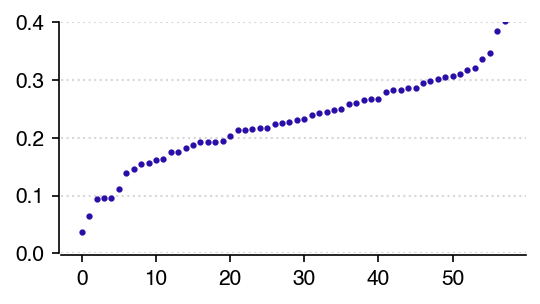

In [11]:
ptc_df = inhib_prop_df.query('pred_ct == "PTC"')
ptc_df["soma_frac_of_close"] = ptc_df["soma_out"] / (
    ptc_df["soma_out"] + ptc_df["proximal_out"]
)
ptc_df = ptc_df.query('tot_out > 50')

fig, ax = plt.subplots(figsize=(4, 2), dpi=150)
ax.plot(
    np.arange(len(ptc_df)),
    ptc_df.sort_values(by="soma_frac_of_close")["soma_frac_of_close"],
    marker="o",
    linestyle="none",
    markersize=2,
    color=ctype_hues["PTC"],
    zorder=10,
)
ax.set_ylim(0, 0.4)
sns.despine(ax=ax, offset=1)
ax.grid(axis='y', linestyle=":", linewidth=1, alpha=0.5)
# fig.savefig(f"{plot_dir}/interneuron_rank_order_soma_frac.pdf", bbox_inches='tight')
# ptc_df.sort_values(by="soma_frac_of_close").to_csv(f"{plot_data_dir}/interneuron_rank_order_soma_frac.csv")

In [ ]:
top_nonsoma = ptc_df.sort_values(by="soma_frac_of_close").head().pt_root_id.values

In [ ]:
fig, ax = plt.subplots(figsize=(4*5, 4), dpi=300)
plot_cell_lineup(
    ptc_df.sort_values(by="soma_frac_of_close").head(),
    ax=ax,
    root_id="pt_root_id",
    hue='pred_ct',
    palette=ctype_hues,
    axon_anno='is_axon',
    layer_bounds=layer_bounds,
    height_bounds=height_bounds,
    spacing_gap=10,
    transform=tform_nm,
)
ax.set_ylim(*height_bounds[::-1])
fig.savefig(f"{plot_dir}/interneurons_morpho_least_soma.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(4*5, 4), dpi=300)
plot_cell_lineup(
    ptc_df.sort_values(by="soma_frac_of_close").tail(),
    ax=ax,
    root_id="pt_root_id",
    hue='pred_ct',
    palette=ctype_hues,
    axon_anno='is_axon',
    layer_bounds=layer_bounds,
    height_bounds=height_bounds,
    spacing_gap=10,
    transform=tform_nm,
)
ax.set_ylim(*height_bounds[::-1])
fig.savefig(f"{plot_dir}/interneurons_morpho_most_soma.pdf", bbox_inches="tight")

In [ ]:
dtc_df = inhib_prop_df.query('pred_ct == "DTC"')
dtc_df['apical_frac_of_close'] = dtc_df['apical_out'] / (dtc_df['apical_out'] + dtc_df['frac_dist'] * dtc_df['exc_out'])
dtc_df = dtc_df.query('tot_out > 50')

fig, ax = plt.subplots(figsize=(4,2), dpi=150)
ax.plot(
    np.arange(len(dtc_df))+1,
    dtc_df.sort_values(by='apical_frac_of_close')['apical_frac_of_close'],
    marker='o',
    linestyle='none',
    markersize=2,
    color=ctype_hues['DTC'],
),
ax.set_ylim(0,1)
sns.despine(ax=ax, offset=1)
ax.grid(axis='y', linestyle=":", linewidth=1, alpha=0.5)
fig.savefig(f"{plot_dir}/interneuron_rank_order_apical_frac.pdf", bbox_inches='tight')
dtc_df.sort_values(by="apical_frac_of_close").to_csv(f"{plot_data_dir}/interneuron_rank_order_apical_frac.csv")

In [ ]:
dtc_df.sort_values(by="apical_frac_of_close").head(5)

In [ ]:
fig, ax = plt.subplots(figsize=(4*5, 4), dpi=300)
plot_cell_lineup(
    dtc_df.sort_values(by="apical_frac_of_close").head(5),
    ax=ax,
    root_id="pt_root_id",
    hue='pred_ct',
    palette=ctype_hues,
    axon_anno='is_axon',
    layer_bounds=layer_bounds,
    height_bounds=height_bounds,
    spacing_gap=10,
    transform=tform_nm,
)
ax.set_ylim(*height_bounds[::-1])
fig.savefig(f"{plot_dir}/interneurons_morpho_least_apical.pdf", bbox_inches="tight")

In [ ]:
fig, ax = plt.subplots(figsize=(4*5, 4), dpi=300)
plot_cell_lineup(
    dtc_df.sort_values(by="apical_frac_of_close").tail(),
    ax=ax,
    root_id="pt_root_id",
    hue='pred_ct',
    palette=ctype_hues,
    axon_anno='is_axon',
    layer_bounds=layer_bounds,
    height_bounds=height_bounds,
    spacing_gap=10,
    transform=tform_nm,
)
ax.set_ylim(*height_bounds[::-1])
fig.savefig(f"{plot_dir}/interneurons_morpho_most_apical.pdf", bbox_inches="tight")

In [ ]:
import glob

In [ ]:
glob.glob(data_dir + '/*')

In [ ]:
itc_df = inhib_prop_df.query('pred_ct == "ITC"')
itc_df = itc_df.query('tot_out > 20')

fig, ax = plt.subplots(figsize=(4, 2), dpi=150)
ax.plot(
    np.arange(len(itc_df)),
    itc_df.sort_values(by="frac_inh")["frac_inh"],
    marker="o",
    linestyle="none",
    markersize=2,
    color=ctype_hues["ITC"],
    zorder=10,
)
ax.set_ylim(0,1)
sns.despine(ax=ax, offset=1)
ax.grid(axis='y', linestyle=":", linewidth=1, alpha=0.5)

In [ ]:
itc_df.sort_values(by="frac_inh").head().pt_root_id.values

In [ ]:
dtc_df.sort_values(by="apical_frac_of_close").tail().pt_root_id.values

In [ ]:
sns.swarmplot(
    x='pred_ct',
    y='frac_inh',
    data=inhib_prop_df,
    hue='pred_ct',
    palette=ctype_hues,
    s=4,
)

In [ ]:
sns.swarmplot(
    x='pred_ct',
    y='frac_soma',
    data=inhib_prop_df,
    hue='pred_ct',
    palette=ctype_hues,
    s=4,
)

In [ ]:
sns.swarmplot(
    x='pred_ct',
    y='frac_proximal',
    data=inhib_prop_df,
    hue='pred_ct',
    palette=ctype_hues,
    s=4,
)

In [ ]:
inhib_prop_df

In [ ]:
sns.swarmplot(
    x='pred_ct',
    y='is_multisyn_all',
    data=inhib_prop_df,
    hue='pred_ct',
    palette=ctype_hues,
    s=4,
)

In [ ]:
axes.ravel()

In [ ]:
fig, axes = plt.subplots(figsize=(12, 4), nrows=2, ncols=4, sharex=True, dpi=150)

vals = [
    "frac_soma",
    "frac_proximal",
    "frac_apical",
    "frac_distal",
    None,
    "frac_inh",
    "is_multisyn_all",
    "is_clumped_all",
]
val_lookup = {
    "frac_soma": "Frac Soma",
    "frac_proximal": "Frac Proximal",
    "frac_apical": "Frac Apical",
    "frac_inh": "Frac Inhibitory",
    "frac_distal": "Frac Distal",
    "is_multisyn_all": "Frac Multisynaptic",
    "is_clumped_all": "Frac Clumped",
}
for val, ax in zip(vals, axes.T.ravel()):
    if val is None:
        ax.set_visible(False)
        continue

    sns.stripplot(
        x="pred_ct",
        y=val,
        data=inhib_prop_df,
        hue="pred_ct",
        palette=ctype_hues,
        s=4,
        ax=ax,
        jitter=0.35,
        alpha=0.25,
        # zorder=-5,
    )

    sns.pointplot(
        x="pred_ct",
        y=val,
        color="k",
        data=inhib_prop_df,
        join=False,
        scale=1,
        errwidth=2,
        estimator=np.median,
        ax=ax,
        # zorder=5,
    )
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel(None)
    ax.set_title(val_lookup.get(val), fontdict={"size": 10})
    ax.set_xlabel(None)
    plt.tight_layout()
    ax.legend().set_visible(False)
    sns.despine(ax=ax, trim=True, offset=4)
    
plt.tight_layout()
fig.savefig(f"{plot_dir}/inhib_properties_strip.pdf", bbox_inches='tight')

---

In [ ]:
from caveclient import CAVEclient
from meshparty import trimesh_vtk, trimesh_io

client = CAVEclient('minnie65_phase3_v1')

In [ ]:
mm = trimesh_io.MeshMeta(cv_path=client.info.segmentation_source(), disk_cache_path='meshes')

In [ ]:
ex_root_id = 864691135687245024
mesh = mm.mesh(seg_id=ex_root_id)

In [ ]:
nrn = fc.io_utils.load_root_id(ex_root_id, project_paths)

In [ ]:
syn_df = nrn.anno.pre_syn.filter_query(nrn.anno.is_axon.mesh_mask).df.copy()
ct_df["in_col"] = True

syn_df = syn_df.merge(
    ct_df[["pt_root_id", "in_col"]],
    how="left",
    left_on="post_pt_root_id",
    right_on="pt_root_id",
).drop(columns="pt_root_id").fillna(False)

In [ ]:
ma = trimesh_vtk.mesh_actor(mesh, color=ctype_hues['DTC'], opacity=0.9)

In [ ]:
syn_pt_un = np.vstack(syn_df.query('~in_col')['ctr_pt_position'].values) * [4,4,40]
syn_pt_col = np.vstack(syn_df.query('in_col')['ctr_pt_position'].values) * [4,4,40]

pca_un = trimesh_vtk.point_cloud_actor(syn_pt_un, size=2000, color=(0.9, 0.9, 0.9), opacity=0.3)
pca_col = trimesh_vtk.point_cloud_actor(syn_pt_col, size=2000, color=(0, 0, 0), opacity=0.7)

In [ ]:
cam = trimesh_vtk.oriented_camera(mesh.centroid, backoff=500)

trimesh_vtk.render_actors([ma, pca_un, pca_col], camera=cam, video_width=1500, video_height=2000)

trimesh_vtk.render_actors([ma], camera=cam, video_width=1500, video_height=2000, do_save=True, filename=f"{plot_dir}/interneuron_example_mesh_only.png")
trimesh_vtk.render_actors([ma, pca_un, pca_col], camera=cam, video_width=1500, video_height=2000, do_save=True, filename=f"{plot_dir}/interneuron_example_with_syn.png")

Examples

----

### Classify each cell type and find important features

In [ ]:
pip install imodels

In [ ]:
from sklearn import ensemble, model_selection, preprocessing, linear_model, metrics
from imblearn import over_sampling
from sklearn.inspection import permutation_importance

scaler = preprocessing.StandardScaler().fit(dfct_e[feat_cols])

In [ ]:
etypes = np.unique(ct_df.query('classification_system == "aibs_coarse_excitatory"')['cell_type'])

In [ ]:
importance_df = pd.DataFrame(index=feat_cols)

In [ ]:
for ct in etypes:
    data_sample, label_sample = over_sampling.SMOTE().fit_resample(
        scaler.transform(dfct_e[feat_cols]),
        dfct_e['hlabel']==ct,
    )
    
    mod = ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8).fit(data_sample, label_sample)
    importance_df[ct] = mod.feature_importances_

In [ ]:
save_figures = True

In [ ]:
fig, ax = plt.subplots(figsize=(5, 2), dpi=300)

sns.heatmap(
    importance_df.T,
    square=True,
    cmap='RdYlBu_r',
    ax=ax,
    vmin=0,
    vmax=0.25,
)

ax.xaxis.set_ticks_position('top')
ax.set_xticks(np.arange(len(feat_cols))+0.5)
ax.set_xticklabels(
    list(col_lookup.values()),
    rotation=90,
    fontdict={'size': 5},
)

ax.set_yticks(np.arange(len(etypes))+0.5)
ax.set_yticklabels(
    etypes,
    fontdict={'size': 5},
)

ax.vlines([15, 21, 26],0,len(etypes),color='w', linewidth=1.25)
if save_figures:
    fig.savefig(f"{plot_dir}/feature_importance_summary.pdf", bbox_inches='tight')

In [ ]:
rfc = ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8)
result = permutation_importance(
    rfc, data_sample, label_sample, n_repeats=10, n_jobs=2
)

In [ ]:
pd.Series(result.importances_mean, index=feat_cols)

In [ ]:
mod.feature_importances_

In [ ]:
from sklearn import ensemble, model_selection, preprocessing, linear_model, metrics

scaler = preprocessing.StandardScaler().fit(dfct_e[feat_cols])
loo = model_selection.LeaveOneOut()

pred_ct = []
for train_inds, test_inds in tqdm.tqdm(loo.split(dfct_e)):
    Xtrain = scaler.transform(dfct_e.iloc[train_inds][feat_cols])
    Ytrain = dfct_e.iloc[train_inds]['hlabel']
    mod = ensemble.RandomForestClassifier(n_estimators=200, n_jobs=8).fit(Xtrain, Ytrain)
    
    Xtest = scaler.transform(dfct_e.iloc[test_inds][feat_cols])
    pred_ct.append(mod.predict(Xtest))

In [ ]:
dfct_e['pred_ct_posthoc'] = np.concatenate(pred_ct)
dfct_e['pred_ct_posthoc'] = dfct_e['pred_ct_posthoc'].astype(dfct_e['hlabel'].dtype)

In [ ]:
dfct_e.pivot_table(
        index="hlabel",
        columns="pred_ct_posthoc",
        values="soma_depth",
        aggfunc="count",
        fill_value=0,
    )

In [ ]:
metrics.f1_score(dfct_e['hlabel'], dfct_e['pred_ct_posthoc'], average='micro')

In [ ]:
mod = linear_model.LogisticRegression(max_iter=500).fit(
    scaler.transform(dfct_e[feat_cols]),
    dfct_e['hlabel'],
)

In [ ]:
fig, ax = plt.subplots(dpi=300)

ax.bar(np.arange(len(mod.feature_importances_)), mod.feature_importances_)
ax.set_xticks(np.arange(len(mod.feature_importances_)))
_=ax.set_xticklabels(feat_cols, rotation=90)

---

In [ ]:
(1.04 - 0.723103) / 0.723103

In [ ]:
(4758.0 - 2649.0) / 2649

In [ ]:
dfct_e.query('hlabel == "L4"')[feat_cols].corr()['max_density']['syn_size_distribution_dendrite_p50']

In [ ]:
dfct_e.query('hlabel == "L4b"')[feat_cols].corr()['max_density']['syn_size_distribution_dendrite_p50']

In [ ]:
dfct_e.query('hlabel == "L4c"')[feat_cols].corr()['max_density']['syn_size_distribution_dendrite_p50']

In [ ]:
dfct_e.groupby('hlabel').median()['max_density']

In [ ]:
sb.render_state(ct_df, return_as='html')